# Data Pre-Processing

### Importing

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import f_classif, VarianceThreshold, SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('learningSet.csv') # original data
df = pd.read_csv('learningSet.csv') # working data

### Fill null values by criteria

In [3]:
def fill_missing_with_mean(df, column):
    df[column].fillna(np.ceil(np.mean(df[column])), inplace=True)

def fill_missing_with_median(df, column):
    median_value = np.ceil(df[column].median(skipna=True))
    df[column] = df[column].fillna(median_value)
    
def fill_missing_with_value(data, column, value):
    data[column].fillna(value, inplace=True)

# DOMAIN is the sum of the codes from DOMAIN A AND B. (A and B don't have nulls)
df['DOMAIN'] = data['DOMAIN_A'] + data['DOMAIN_B'].astype(str)

# empty SOLIH means that there is no limit for marketing solicitation from the customer
fill_missing_with_value(df, 'SOLIH', 365)

# 22% of income is null and is the leading category. I prefer to add a new label
fill_missing_with_value(df, 'INCOME', 0)

# Fill with the mode
fill_missing_with_value(df, 'GENDER', 'F')

# Fill missing values with the mean for 'DMA', 'CLUSTER2'
for column in ['DMA', 'CLUSTER2']:
    fill_missing_with_mean(df, column)

# Fill 'TIMELAG' and 'NEXTDATE' with the ceiling of the median
for column in ['TIMELAG', 'NEXTDATE']:
    fill_missing_with_median(df, column)
    
# Fill cluster with the mode - 2.5% nulls
fill_missing_with_value(df, 'CLUSTER', '40.0')

# High irrelevancy - indicates with 22% nulls the source of the data
fill_missing_with_value(df, 'DATASRCE', '0')

# home owner flag - 23% nulls
fill_missing_with_value(df, 'HOMEOWNR', 'U')

def map_geocode(x):
    if x not in ['A','B','C','D']:
        return 'O'
    else:
        return x
df['GEOCODE2'] = df['GEOCODE2'].apply(map_geocode)

# For the columns that collect the reactions to magazine when null value is assumed that there is not reaction (no reaction=no information)
columns_to_fill_zero = [
    "MBCRAFT", "MBGARDEN", "MBBOOKS", "MBCOLECT", "MAGFAML", "MAGFEM", "MAGMALE",
    "PUBGARDN", "PUBCULIN", "PUBHLTH", "PUBDOITY", "PUBNEWFN", "PUBPHOTO", "PUBOPP"
]
for column in columns_to_fill_zero:
    df[column] = df[column].fillna(0)


### Dropping by % of null values

In [4]:
def calculate_null_percentages(df, threshold=0.33):
    nulls_percent_df = pd.DataFrame(df.isna().sum() / len(df)).reset_index()
    nulls_percent_df.columns = ['column_name', 'nulls_percentage']
    return nulls_percent_df[nulls_percent_df['nulls_percentage'] > threshold]
drop_columns_list = list(set(calculate_null_percentages(df)['column_name']))


### Dropping by relevance

In [5]:
# OSOURCE - symbol definitions not provided, too many categories 
# ZIP - we are including state already
# MAILCODE is a flag for correctness of the address 98.5% are correct (94013/95412)
# NOEXCH is another flag stating "Do Not Exchange" Flag (For list rental)
# AGEFLAG states if the age is Exact or Inferred from Date of Birth Field
# VETERANS (Y/N)
irrelevant_list = ['OSOURCE', 'ZIP', 'MAILCODE', 'NOEXCH', 'AGEFLAG','VETERANS']
# ADATE = Dates of past campaings
adate_columns = [col for col in df.columns if "ADATE_" in col]

drop_columns_list += irrelevant_list + adate_columns


### Dropping by redundancy

In [6]:
redundant_list = ['WEALTH2','MSA', 'ADI','MAILCODE', 'DOMAIN_A','DOMAIN_B', 'MDMAUD']
mdmaud_columns_rfa_columns = [col for col in data.columns if ("RFA_" in col or "MDMAUD_" in col)]

# RFA_* (with RFA), MDMAUD_* (with MDMAUD). All dropped due to redundancy
# Wealth 2 may be redundant in front of ICX Census data.
# MSA, ADI, DMA are local market designations based on marketing communication. ADI and DMA give similar segmentations (but ranked differently), MSA takes only county clusters above 50,000 inhabitants.
# Domain A and B as they are integrated in DOMAIN
# MDMAUD is in MAJOR

drop_columns_list += redundant_list + mdmaud_columns_rfa_columns

In [7]:
df.drop(columns=drop_columns_list, inplace=True)

### Condensing groups

In [8]:
def map_gender(x):
    return x if x in ['F', 'M'] else 'other'
df['GENDER'] = df['GENDER'].apply(map_gender)

    
state_count = df['STATE'].value_counts().reset_index()
state_count.columns = ['state', 'count']
other_states = state_count[state_count['count'] < 2500]['state'].tolist()

def map_state(x):
    return 'other' if x in other_states else x
df['STATE'] = df['STATE'].apply(map_state)

### Mapping for rebuild categories.

In [9]:
names = ['1', '2', '3', '4', '5']
age_group = df['AGE']
age_group = pd.cut(age_group,bins=5,labels=names, include_lowest=True)
default = 6
age_group= age_group.cat.add_categories([default])
age_group = age_group.fillna(default)
df['AGE'] = age_group

In [10]:
# Count nulls, reset index, and filter columns with nulls
null_count = df.isnull().sum().reset_index().rename(columns={'index': 'column', 0: 'nulls'})
null_count = null_count[null_count['nulls'] > 0]
null_count

,column,nulls


### Select data by type: 
### Separate into numerical and categorical

In [11]:
Y = df[['TARGET_B', 'TARGET_D']]
numerical = df.select_dtypes('number').drop(columns = ['TARGET_B', 'TARGET_D'])
categorical = df.select_dtypes('object')
# In this summary the division by data type is done in a second phase
print(numerical.shape)
print(categorical.shape)

(95412, 344)
(95412, 36)


### Space values

In [12]:
# Assuming 'df' is your DataFrame
string_to_count = ' '

# Define a function that safely applies the count method to strings
def safe_count(x):
    if isinstance(x, str):
        return x.count(string_to_count)
    else:
        return 0

# Apply the safe_count function to each element of the DataFrame
counts = df.applymap(safe_count).sum()

# Filter the counts to only show columns with a count greater than 0
counts = counts[counts > 0]

# This will give you a Series with the count of the string in each column where the count is greater than 0
print(counts)

# According to further documentation 

# Blank PEPSTRFL is no PEP Star
# Are binary categories eligible for a negative statement sustitution PEPSTRFL, RECINHSE, RECP3, RECPGVG, RECSWEEP, PVASTATE, MAJOR (pd.concat([data['MDMAUD'], df['MAJOR']],axis=1).value_counts())^1, COLLECT1, BIBLE, CATLG, HOMEE, PETS,CDPLAY, STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES
# Non binary categories but still eligible for negative statement sustitution CHILD* (with N), SOLP3 (change with 365), HOMEOWNR but the negative label is already defined 'U',
# ^1 there is an error in MAJOR column description as X is indicating major donors where the document says the opposite, but after comparing with MDMAUD is clear.

PVASTATE    93954
RECINHSE    88709
RECP3       93395
RECPGVG     95298
RECSWEEP    93795
HOMEOWNR    22228
CHILD03     94266
CHILD07     93846
CHILD12     93601
CHILD18     92565
SOLP3       95232
MAJOR       95118
COLLECT1    90210
BIBLE       86541
CATLG       87547
HOMEE       94525
PETS        81086
CDPLAY      83158
STEREO      82618
PCOWNERS    84931
PHOTO       90626
CRAFTS      87236
FISHER      88282
GARDENIN    82010
BOATS       93384
WALKER      84911
KIDSTUFF    93876
CARDS       94371
PLATES      94852
PEPSTRFL    50143
dtype: int64


In [13]:
# Replace space values with "365" in the "SOLP3" column
categorical['SOLP3'] = categorical['SOLP3'].replace(' ', '365')
# Replace space values with "U" in the "HOMEOWNR" column
categorical['HOMEOWNR'] = categorical['HOMEOWNR'].replace(' ', 'U')

def replace_space_with_N(columns, dataframe):
    for column in columns:
        dataframe[column] = dataframe[column].apply(lambda x: 'N' if x == ' ' else x)
    return dataframe

# List of columns to apply the replacement
columns_to_replace = [
    'PEPSTRFL', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP', 'PVASTATE', 'MAJOR',
    'COLLECT1', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS',
    'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES'
]

# Apply the function to the 'categorical' DataFrame
categorical = replace_space_with_N(columns_to_replace, categorical)

# Replace space values with "N" in columns that start with "CHILD"
child_columns = [col for col in categorical.columns if col.startswith('CHILD')]
categorical = replace_space_with_N(child_columns, categorical)

In [14]:
counts_2 = categorical.applymap(safe_count).sum()

# Filter the counts to only show columns with a count greater than 0
counts = counts_2[counts_2 > 0]

# This will give you a Series with the count of the string in each column where the count is greater than 0
print(counts)

Series([], dtype: int64)


### Check distribution

In [15]:
# import pandas as pd
# import plotly.express as px

# for column in numerical.columns:
#     fig = px.histogram(numerical, x=column)
#     fig.show()

### Split

In [16]:
# Combine features
X = pd.concat([numerical, categorical], axis=1)
y = df['TARGET_B']

X2 = X
y2 = df['TARGET_D']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [17]:
X_train_cat = X_train.select_dtypes(include = object).astype(str)
X_train_num =X_train.select_dtypes(include = np.number)
X_test_cat = X_test.select_dtypes(include = object).astype(str)
X_test_num =X_test.select_dtypes(include = np.number)

# Target B

### Encode and scale

In [18]:
# Encode categorical features
encoder = OneHotEncoder(drop='first').fit(X_train_cat.select_dtypes(include=object))

cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)
X_train_cat_encode = pd.DataFrame(encoder.transform(X_train_cat).toarray(),columns=cols)
X_train_cat_encode.reset_index(drop = True, inplace = True)

cols = encoder.get_feature_names_out(input_features=X_test_cat.columns)
X_test_cat_encode = pd.DataFrame(encoder.transform(X_test_cat).toarray(),columns=cols)
X_test_cat_encode.reset_index(drop = True, inplace = True)

# Scale numerical features
transformer = MinMaxScaler().fit(X_train_num)

X_train_num_norm = transformer.transform(X_train_num)
X_train_num_scale = pd.DataFrame(X_train_num_norm, index = X_train_num.index, columns=X_train_num.columns)
X_train_num_scale.reset_index(drop = True, inplace = True)

X_test_num_norm = transformer.transform(X_test_num)
X_test_num_scale = pd.DataFrame(X_test_num_norm, index = X_test_num.index, columns=X_test_num.columns)
X_test_num_scale.reset_index(drop = True, inplace=True)


# Concatenate X train and test and resume y train and y test
X_train_processed = pd.concat([X_train_num_scale,X_train_cat_encode], axis=1)
y_train.reset_index(drop = True, inplace = True)

X_test_processed = pd.concat([X_test_num_scale,X_test_cat_encode], axis=1)
y_test.reset_index(drop = True, inplace = True)

### Feature selection (Variance Threshold)

In [19]:
# Feature selection based on a variance threshold. Does not consider the relationship between features and the target variable.

var_threshold = 0.13
selector_var = VarianceThreshold(threshold=var_threshold)
X_train_var = selector_var.fit_transform(X_train_processed)
X_test_var = selector_var.transform(X_test_processed)

indices_var = selector_var.get_support(indices=True)
len(indices_var)

19

In [20]:
# selector_var.variances_ > var_threshold

### Feature selection (SelectKBest)

In [21]:
# Select features that have the strongest relationship with the target variable, based on the chi-squared statistic. Only positive values, and the best for categorical. 

selector_chi2 = SelectKBest(chi2, k=20)
X_train_chi2 = selector_chi2.fit_transform(X_train_processed, y_train)
X_test_chi2 = selector_chi2.transform(X_test_processed)

indices_chi2 = selector_chi2.get_support(indices=True)
len(indices_chi2)

20

### Feature selection (ANOVA F-test)

In [22]:
# Selection based on univariate statistical tests. May not capture non-linear relationships as effectively. Good for numerical and categorical

selector_f = SelectKBest(f_classif, k=20)
X_train_f_test = selector_f.fit_transform(X_train_processed, y_train)
X_test_f_test = selector_f.transform(X_test_processed)

indices_f = selector_f.get_support(indices=True)
len(indices_f)

20

### Feature selection (Random Forest)

In [23]:
# An ensemble method that uses feature importance scores from the Random Forest classifier to select features. Computational intensive. Good for numerical and categorical.Can capture both linear and non-linear relationships; provides feature importance scores.

forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train_processed, y_train)
importances = forest.feature_importances_


indices_rf = np.argsort(importances)[::-1][:20]  # Top 20 features

### Feature comparison table

In [24]:
%time

# Find the maximum length of the lists
max_length = max(len(indices_var), len(indices_chi2), len(indices_f), len(indices_rf))

# Function to pad lists to the maximum length
def pad_list(lst, length, pad_value):
    return lst + [pad_value] * (length - len(lst))

# Pad the lists
indices_var_padded = pad_list(list(X_train_processed.columns[indices_var]), max_length, None)
indices_chi2_padded = pad_list(list(X_train_processed.columns[indices_chi2]), max_length, None)
indices_f_padded = pad_list(list(X_train_processed.columns[indices_f]), max_length, None)
indices_rf_padded = pad_list(list(X_train_processed.columns[indices_rf]), max_length, None)

# Sort each column individually
sorted_var = sorted([x for x in indices_var_padded if x is not None])
sorted_chi2 = sorted([x for x in indices_chi2_padded if x is not None])
sorted_f = sorted([x for x in indices_f_padded if x is not None])
sorted_rf = sorted([x for x in indices_rf_padded if x is not None])

# Pad the sorted lists to the maximum length
sorted_var_padded = pad_list(sorted_var, max_length, None)
sorted_chi2_padded = pad_list(sorted_chi2, max_length, None)
sorted_f_padded = pad_list(sorted_f, max_length, None)
sorted_rf_padded = pad_list(sorted_rf, max_length, None)

# Now create the DataFrame with sorted columns
sorted_comparison_df = pd.DataFrame({
    'Variance Threshold': sorted_var_padded,
    'SelectKBest chi2': sorted_chi2_padded,
    'ANOVA F-test': sorted_f_padded,
    'Random Forest': sorted_rf_padded
})

print(sorted_comparison_df)


CPU times: total: 0 ns
Wall time: 0 ns
   Variance Threshold SelectKBest chi2  ANOVA F-test Random Forest
0        DATASRCE_2.0         CARDGIFT       AVGGIFT       AVGGIFT
1        DATASRCE_3.0     CLUSTER_32.0      CARDGIFT      CARDGIFT
2           DOMAIN_R2     CLUSTER_40.0      CARDPROM      CARDPROM
3        FIRSTDATE_MM        DOMAIN_C3  FIRSTDATE_YR      CONTROLN
4            GENDER_M             ETH2      FISTDATE           DOB
5          GEOCODE2_B             HVP1           HV1      FISTDATE
6          GEOCODE2_C             HVP2           HV2           HV1
7          GEOCODE2_D             HVP3          HVP3      LASTGIFT
8          HOMEOWNR_U             HVP4          HVP4      MAXRAMNT
9            HPHONE_D             HVP6      LASTDATE      MAXRDATE
10               HVP3         LASTDATE   LASTDATE_YR      MINRDATE
11               HVP4      LASTDATE_YR      LASTGIFT      NEXTDATE
12        LASTDATE_MM          ODATEDW      MINRAMNT      NGIFTALL
13               LFC9  

### Looking at multicolinearity

CPU times: total: 0 ns
Wall time: 0 ns


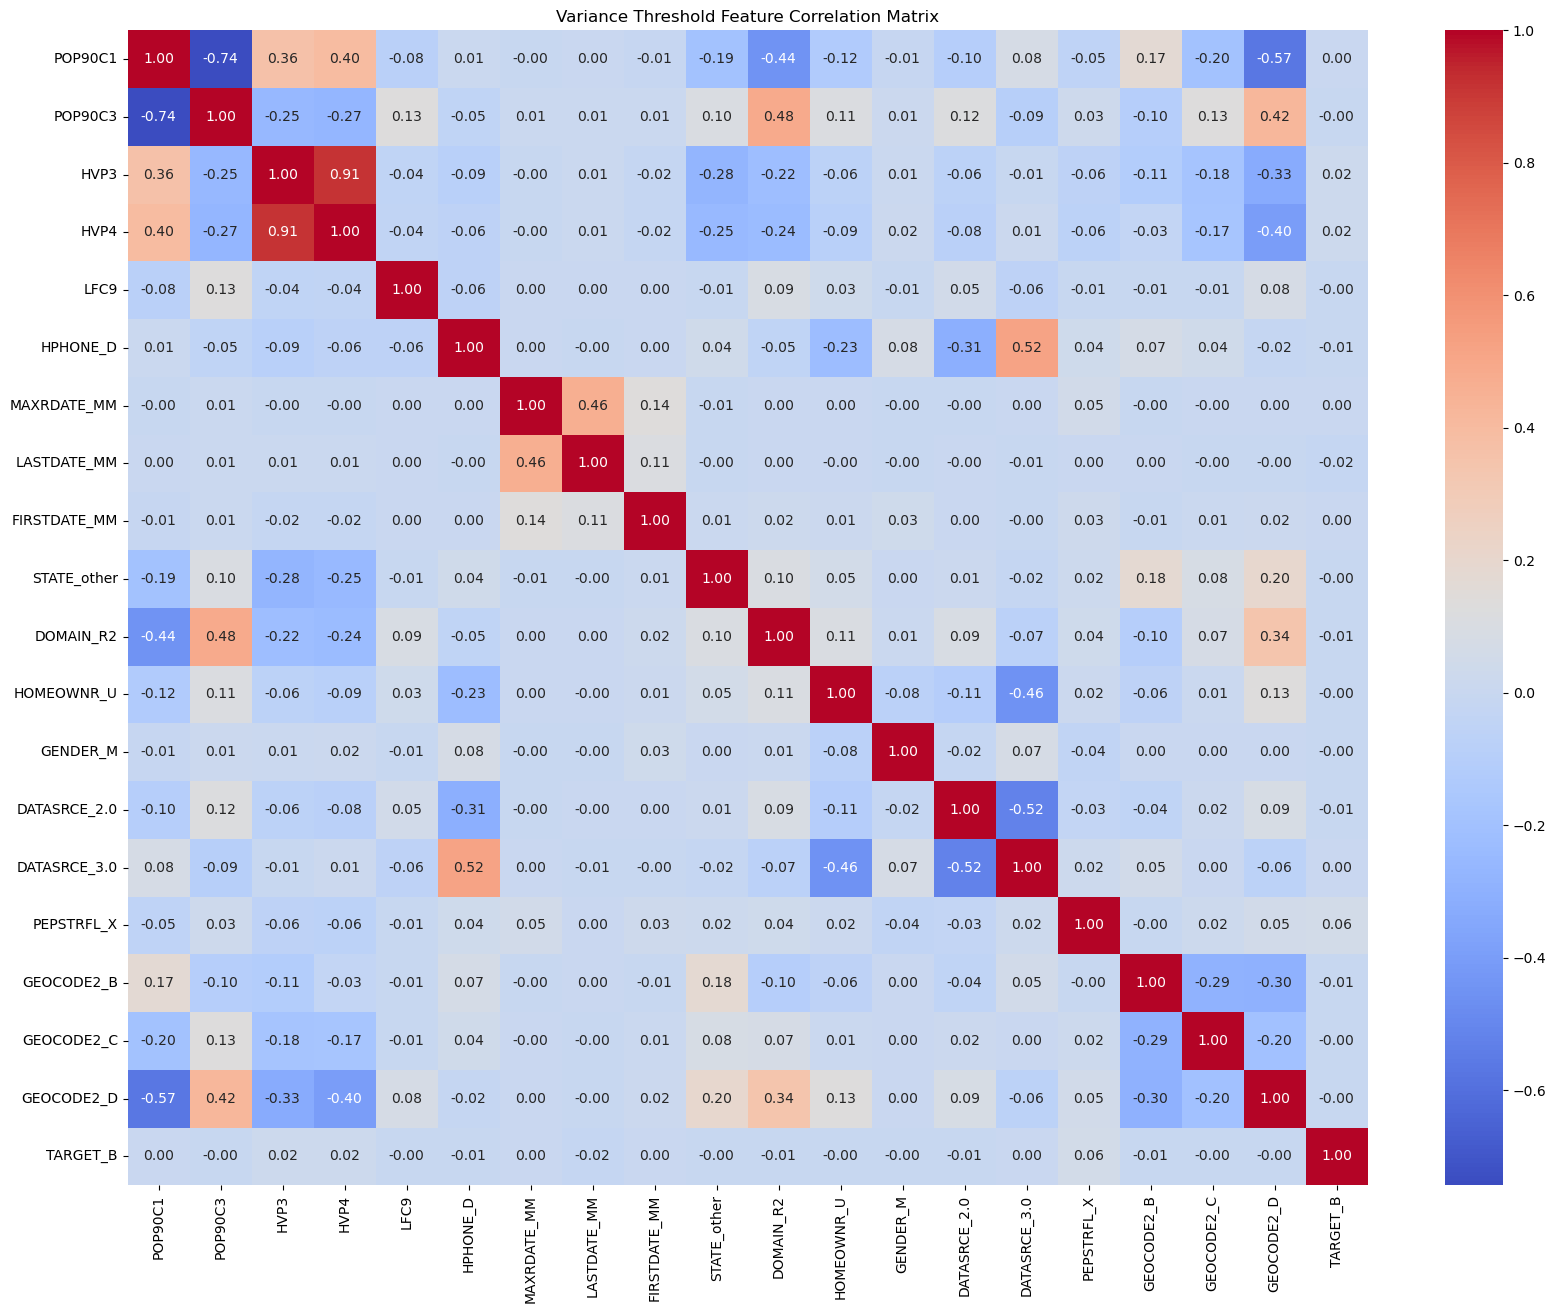

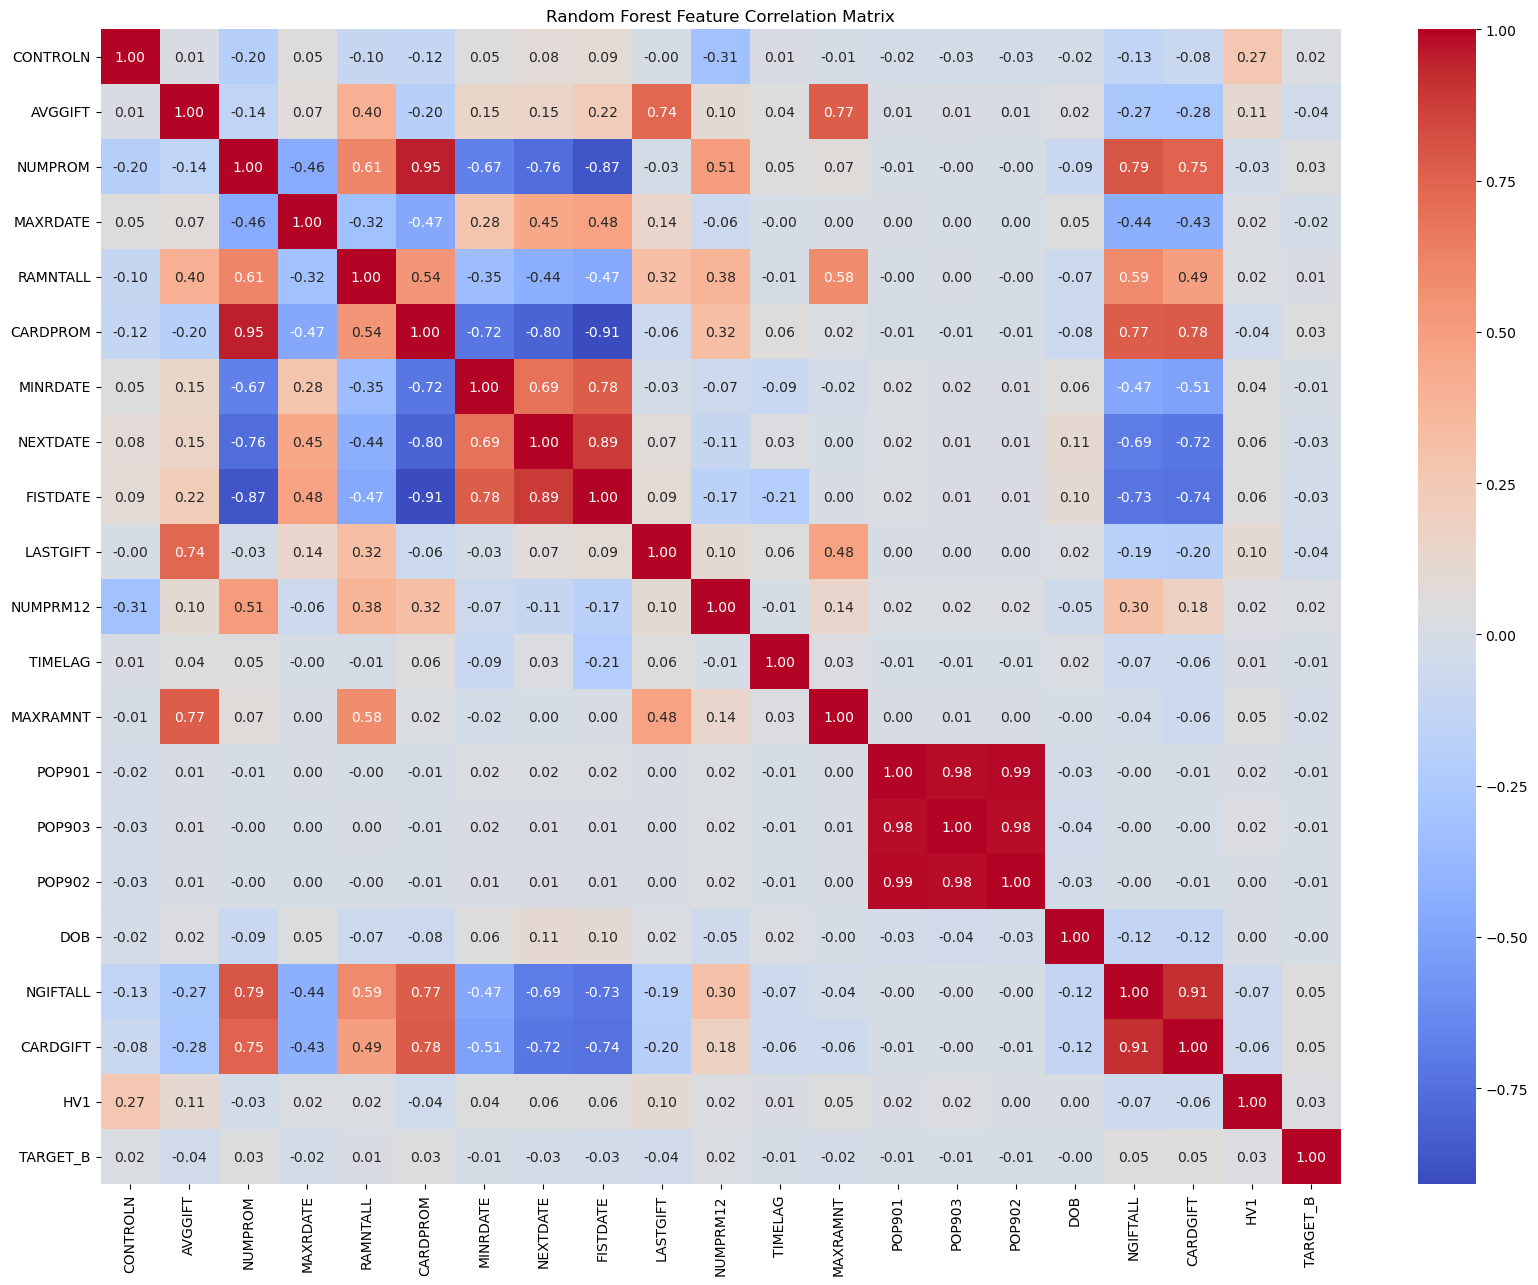

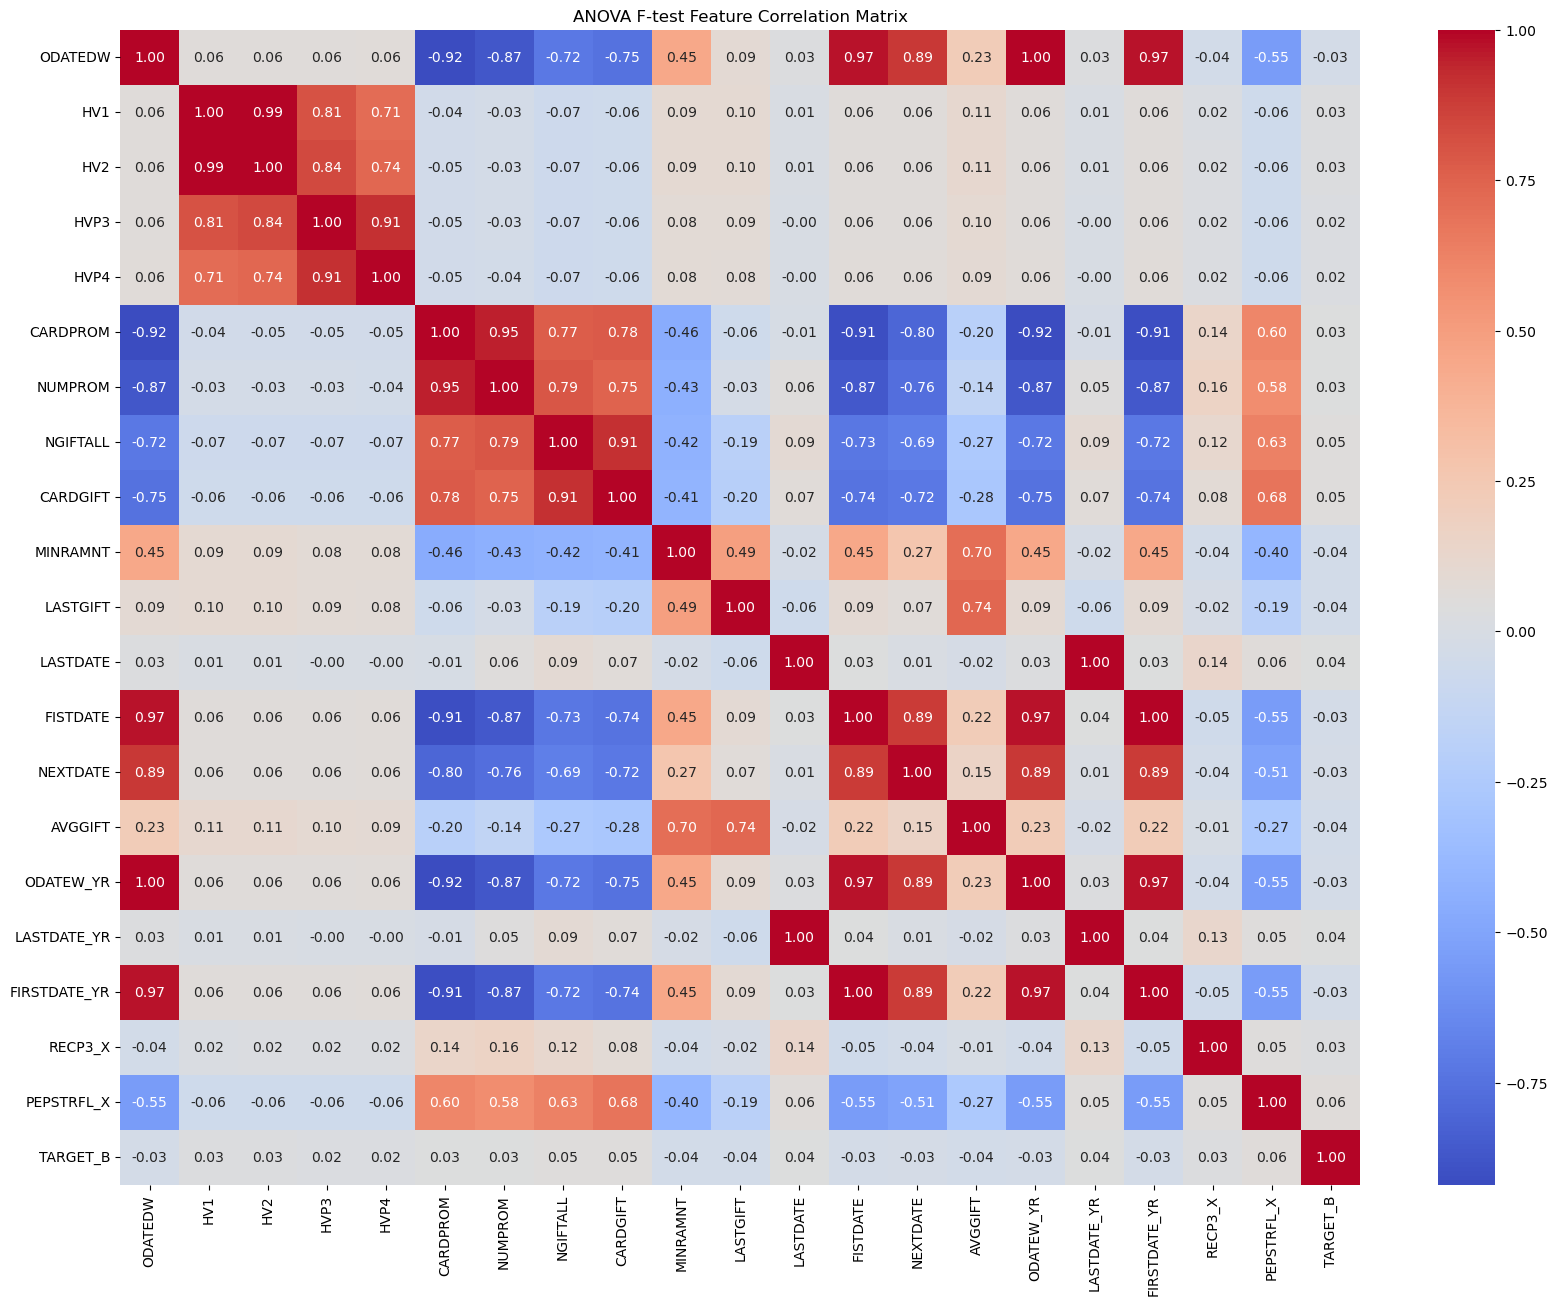

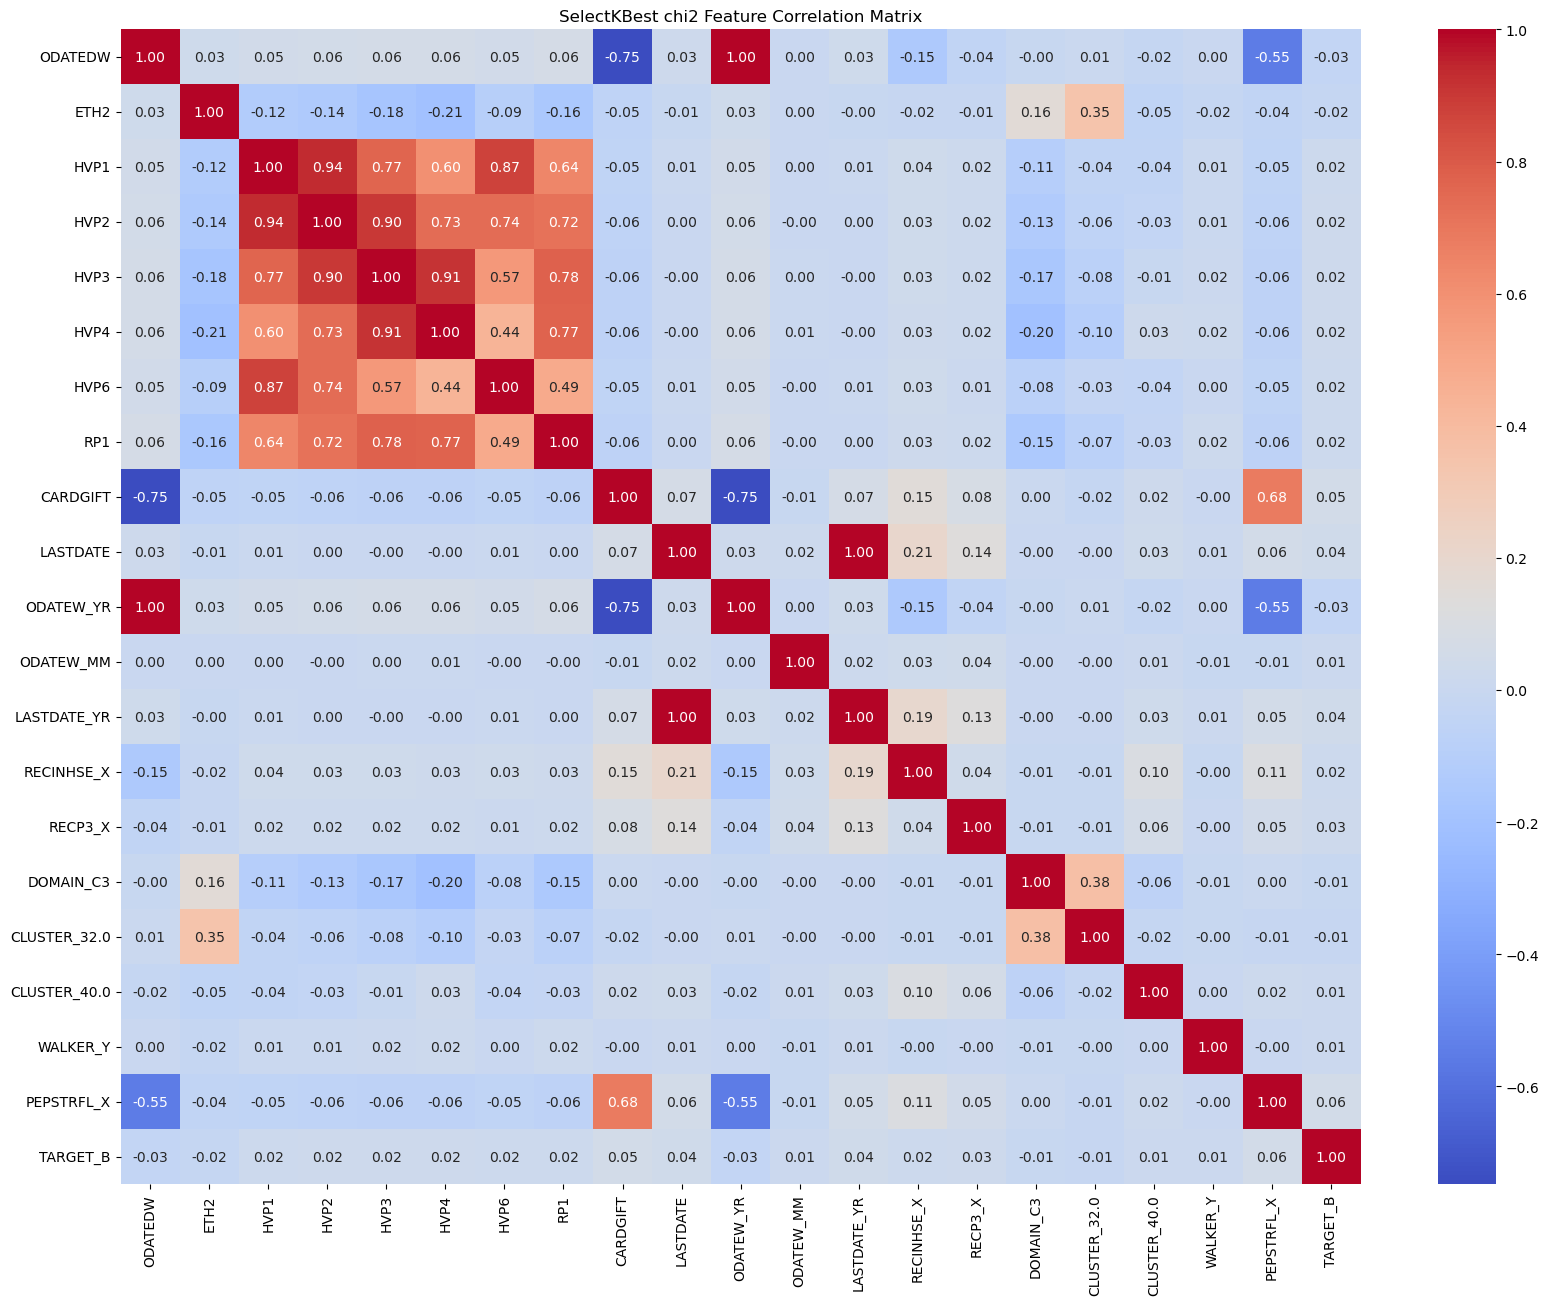

In [25]:
%time

# Create the X_train datasets based on selected features
X_train_var = X_train_processed.iloc[:, indices_var]
X_train_rf = X_train_processed.iloc[:, indices_rf]
X_train_f = X_train_processed.iloc[:, indices_f]
X_train_chi2 = X_train_processed.iloc[:, indices_chi2]

X_test_var = X_test_processed.iloc[:, indices_var]
X_test_rf = X_test_processed.iloc[:, indices_rf]
X_test_f = X_test_processed.iloc[:, indices_f]
X_test_chi2 = X_test_processed.iloc[:, indices_chi2]

# Define a function to compute and plot the correlation matrix
def plot_correlation_matrix(X, title):
    corr_matrix = pd.concat([X,y_train], axis=1).corr(method='pearson')
    plt.figure(figsize=(20, 15))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title(title)
    plt.show()

# Plot the correlation matrix for each X_train dataset
plot_correlation_matrix(X_train_var, 'Variance Threshold Feature Correlation Matrix')
plot_correlation_matrix(X_train_rf, 'Random Forest Feature Correlation Matrix')
plot_correlation_matrix(X_train_f, 'ANOVA F-test Feature Correlation Matrix')
plot_correlation_matrix(X_train_chi2, 'SelectKBest chi2 Feature Correlation Matrix')


### Drop highest multi-collinearity.

In [26]:
# High correlation between features in the following cases:
# X_train_var: POP90C1, HVP4
# X_train_rf: MINRDATE, FISTDATE, CARDPROM, POP903, POP902, NGIFTALL
# X_train_f: HV2, HVP4, CARDPROM, FISTDATE,FISTDATE_YR 
# X_train_chi2: HV2, HV3, HV4, HV6

In [27]:
def drop_columns(df, columns_to_drop):
    df = df.drop(columns_to_drop, axis=1, errors='ignore')
    return df

# Drop the specified columns from X_train_var and X_test_var
X_train_var = drop_columns(X_train_var, ['POP90C1', 'HVP4'])
X_test_var = drop_columns(X_test_var, ['POP90C1', 'HVP4'])

# Drop the specified columns from X_train_rf and X_test_rf
X_train_rf = drop_columns(X_train_rf, ['MINRDATE', 'FISTDATE', 'CARDPROM', 'POP903', 'POP902', 'NGIFTALL'])
X_test_rf = drop_columns(X_test_rf, ['MINRDATE', 'FISTDATE', 'CARDPROM', 'POP903', 'POP902', 'NGIFTALL'])

# Drop the specified columns from X_train_f and X_test_f
X_train_f = drop_columns(X_train_f, ['HV2', 'HVP4', 'CARDPROM', 'FISTDATE', 'FISTDATE_YR'])
X_test_f = drop_columns(X_test_f, ['HV2', 'HVP4', 'CARDPROM', 'FISTDATE', 'FISTDATE_YR'])

# Drop the specified columns from X_train_chi2 and X_test_chi2
X_train_chi2 = drop_columns(X_train_chi2, ['HV2', 'HV3', 'HV4', 'HV6'])
X_test_chi2 = drop_columns(X_test_chi2, ['HV2', 'HV3', 'HV4', 'HV6'])


### Pre-Model

CPU times: total: 0 ns
Wall time: 0 ns
X_train_var - TrainSet Accuracy:  0.9900730670180272
X_train_var - TestSet Accuracy:  0.9497624371157071


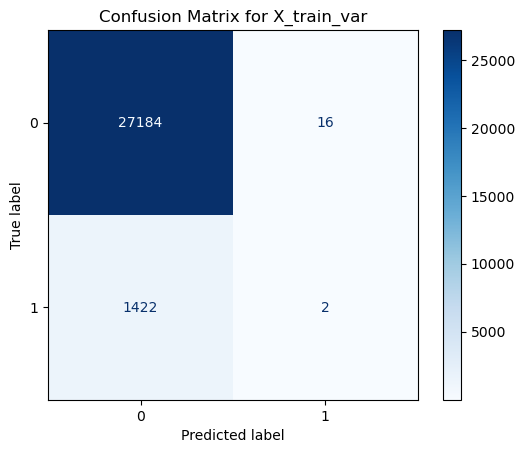

X_train_rf - TrainSet Accuracy:  0.9619392705276397
X_train_rf - TestSet Accuracy:  0.9502515371716043


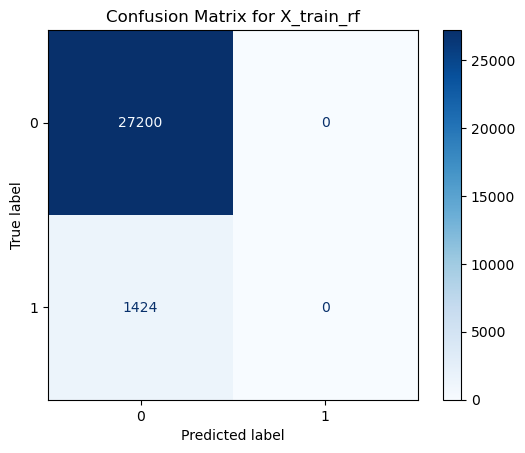

X_train_f - TrainSet Accuracy:  0.9626280170090435
X_train_f - TestSet Accuracy:  0.9503563443264393


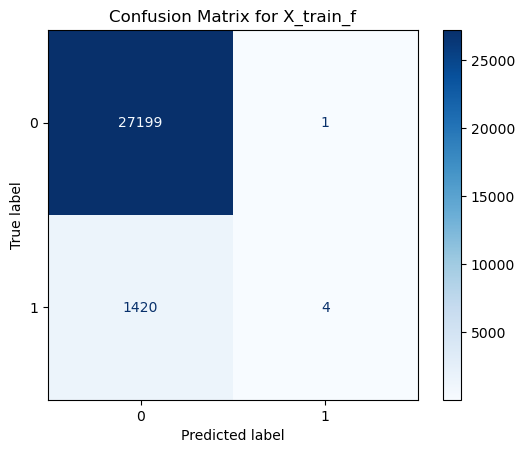

X_train_chi2 - TrainSet Accuracy:  0.9640204827214469
X_train_chi2 - TestSet Accuracy:  0.9502864728898827


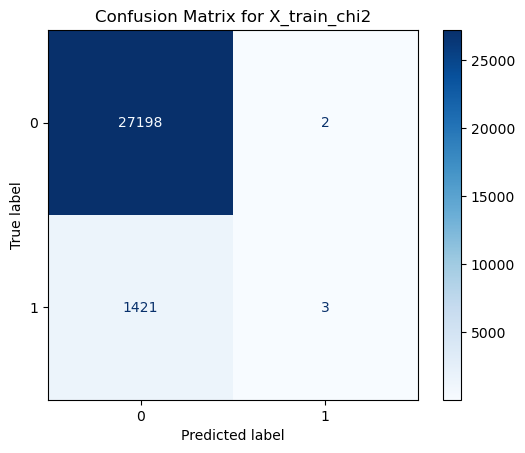

In [28]:
%time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(X_train, X_test, y_train, y_test, model_name):
    clf = RandomForestClassifier(
    n_estimators=100,      # More trees can lead to better performance but also to longer training times
    max_depth=20,          # Deeper trees capturing more complex patterns. Be cautious, as too much depth can lead to overfitting
    min_samples_split=2,   # Minimum number of samples required to split an internal node. Lower values allow the algorithm to create more specific splits, thus increasing complexity.
    min_samples_leaf=1,    # Minimum number of samples required to be at a leaf node. Smaller leaf sizes result in more complex decision paths
    )
    clf.fit(X_train, y_train)
    train_accuracy = clf.score(X_train, y_train)
    test_accuracy = clf.score(X_test, y_test)
    print(f'{model_name} - TrainSet Accuracy: ', train_accuracy)
    print(f'{model_name} - TestSet Accuracy: ', test_accuracy)
    
    # Compute confusion matrix
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    TP = cm[1, 1]  # True Positives
    TN = cm[0, 0]  # True Negatives
    FP = cm[0, 1]  # False Positives
    FN = cm[1, 0]  # False Negatives
    
    # Plotting the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    return train_accuracy, test_accuracy, TP, TN, FP, FN

train_acc_var, test_acc_var, tp_var, tn_var, fp_var, fn_var = evaluate_model(X_train_var, X_test_var, y_train, y_test, 'X_train_var')
train_acc_rf, test_acc_rf, tp_rf, tn_rf, fp_rf, fn_rf = evaluate_model(X_train_rf, X_test_rf, y_train, y_test, 'X_train_rf')
train_acc_f, test_acc_f, tp_f, tn_f, fp_f, fn_f = evaluate_model(X_train_f, X_test_f, y_train, y_test, 'X_train_f')
train_acc_chi2, test_acc_chi2, tp_chi2, tn_chi2, fp_chi2, fn_chi2 = evaluate_model(X_train_chi2, X_test_chi2, y_train, y_test, 'X_train_chi2')

### Check and fix Target imbalance

In [29]:
print(y_train.value_counts())
target_d_1 = len(y2_train[y2_train>0])
target_d_0 = len(y2_train)
print('TARGET_D\n', target_d_0, '\n', target_d_1)

TARGET_B
0    63369
1     3419
Name: count, dtype: int64
TARGET_D
 66788 
 3419


In [30]:
from sklearn.utils import resample

# Concatenate for X
df = pd.concat([X_train_processed,X_test_processed], axis=0).reset_index()
# Transform for y
y_df = pd.DataFrame(y, columns=['TARGET_B'])
y2_df = pd.DataFrame(y2, columns=['TARGET_D'])
# Concatenate for resampling
df_b = pd.concat([df, y_df], axis=1)
df_d = pd.concat([df, y2_df], axis=1)

# Separate the majority and minority classes
df_b_majority = df_b[df_b.TARGET_B == 0]
df_b_minority = df_b[df_b.TARGET_B == 1]

df_d_majority = df_d[df_d.TARGET_D == 0]
df_d_minority = df_d[df_d.TARGET_D > 0]


# Upsample minority class
df_b_minority_upsampled = resample(df_b_minority, 
                                 replace=True,
                                 n_samples=len(df_b_majority),
                                 random_state=101)

df_d_minority_upsampled = resample(df_d_minority, 
                                 replace=True,
                                 n_samples=len(df_d_majority),
                                 random_state=101)


# Combine majority class with upsampled minority class
df_b_upsampled = pd.concat([df_b_majority, df_b_minority_upsampled])
df_d_upsampled = pd.concat([df_d_majority, df_d_minority_upsampled])

# Display new class counts
print(df_b_upsampled.TARGET_B.value_counts())
print(df_d_upsampled.TARGET_D.value_counts())

# X and Y for TARGET B
X_upsampled = df_b_upsampled.drop('TARGET_B', axis=1)
y_upsampled = df_b_upsampled.TARGET_B

# X and Y for TARGET B
X2_upsampled = df_d_upsampled.drop('TARGET_D', axis=1)
y2_upsampled = df_d_upsampled.TARGET_D


TARGET_B
0    90569
1    90569
Name: count, dtype: int64
TARGET_D
0      90569
10     17509
15     10901
20     10869
5       9407
25      7421
12      3167
6       2374
7       2354
8       2197
11      2167
30      1870
21      1764
16      1630
3       1605
14      1580
4       1415
9       1313
50      1279
13      1196
17      1163
35       766
18       703
23       696
26       522
19       503
40       495
22       455
2        436
100      401
32       244
24       239
36       167
27       160
38       152
75       131
45       130
47       112
1        108
28       102
37       101
200       94
33        66
44        66
51        58
29        49
31        49
60        48
53        39
34        39
46        36
42        36
43        35
41        32
101       26
95        20
150       19
55        19
102       17
48        17
Name: count, dtype: int64


### Split

In [31]:
# Sort indices
X_upsampled.sort_index(inplace=True)
y_upsampled.sort_index(inplace=True)

In [32]:
# Split data
X_train_var_up, X_test_var_up, y_upsampled_train_var, y_upsampled_test_var = train_test_split(
    X_upsampled.iloc[:, indices_var], y_upsampled, test_size=0.3, random_state=42
)

X_train_rf_up, X_test_rf_up, y_upsampled_train_rf, y_upsampled_test_rf = train_test_split(
    X_upsampled.iloc[:, indices_rf], y_upsampled, test_size=0.3, random_state=42
)

X_train_f_up, X_test_f_up, y_upsampled_train_f, y_upsampled_test_f = train_test_split(
    X_upsampled.iloc[:, indices_f], y_upsampled, test_size=0.3, random_state=42
)


X_train_chi2_up, X_test_chi2_up, y_upsampled_train_chi2, y_upsampled_test_chi2 = train_test_split(
    X_upsampled.iloc[:, indices_chi2], y_upsampled, test_size=0.3, random_state=42
)


In [33]:
# Verify lengths and indices
# assert len(X_train_var_up) == len(y_upsampled_train_var)
# assert len(X_test_var_up) == len(y_upsampled_test_var)
# assert X_train_var_up.index.equals(y_upsampled_train_var.index)
# assert X_test_var_up.index.equals(y_upsampled_test_var.index)

### Model

X_train_var - TrainSet Accuracy:  0.9945108678507208
X_train_var - TestSet Accuracy:  0.9874682565971072


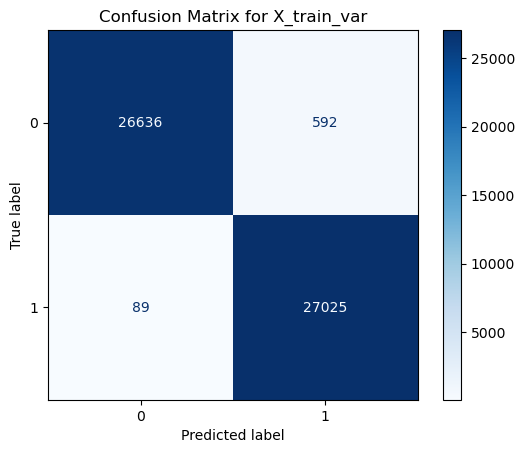

X_train_rf - TrainSet Accuracy:  0.987412852140446
X_train_rf - TestSet Accuracy:  0.9780464465790732


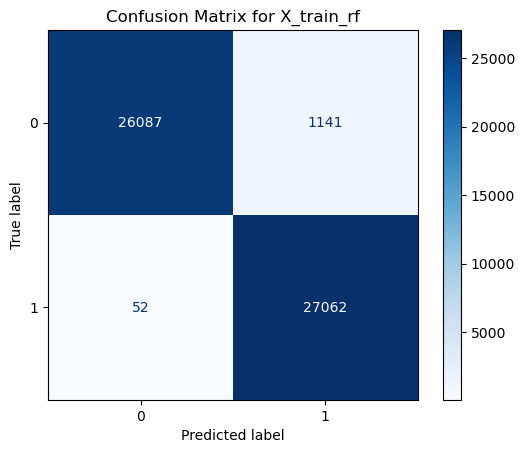

X_train_f - TrainSet Accuracy:  0.9970267200858072
X_train_f - TestSet Accuracy:  0.9935777115306761


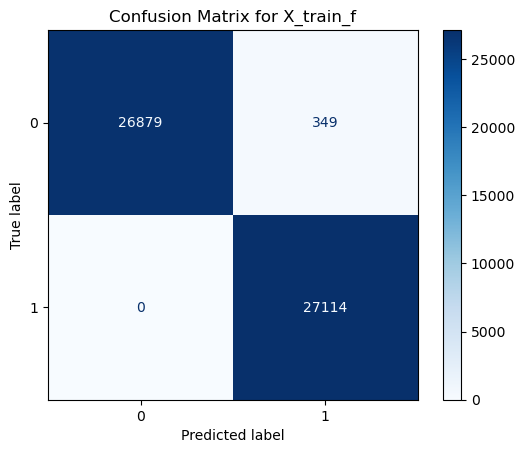

X_train_chi2 - TrainSet Accuracy:  0.9984068898072495
X_train_chi2 - TestSet Accuracy:  0.9946818298921645


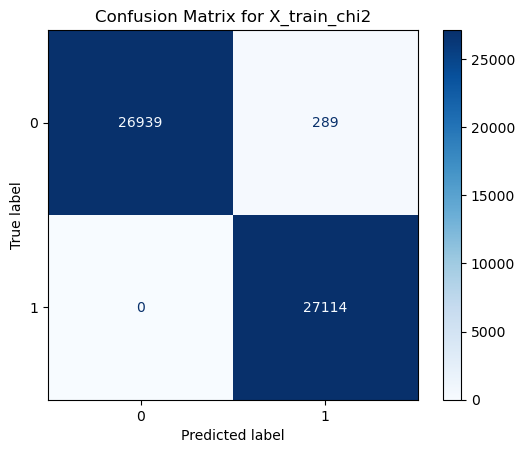

In [34]:
train_acc_var_up, test_acc_var_up, tp_var_up, tn_var_up, fp_var_up, fn_var_up = evaluate_model(X_train_var_up, X_test_var_up, y_upsampled_train_var, y_upsampled_test_var, 'X_train_var')
train_acc_rf_up, test_acc_rf_up, tp_rf_up, tn_rf_up, fp_rf_up, fn_rf_up = evaluate_model(X_train_rf_up, X_test_rf_up, y_upsampled_train_rf, y_upsampled_test_rf, 'X_train_rf')
train_acc_f_up, test_acc_f_up, tp_f_up, tn_f_up, fp_f_up, fn_f_up = evaluate_model(X_train_f_up, X_test_f_up, y_upsampled_train_f, y_upsampled_test_f, 'X_train_f')
train_acc_chi2_up, test_acc_chi2_up, tp_chi2_up, tn_chi2_up, fp_chi2_up, fn_chi2_up = evaluate_model(X_train_chi2_up, X_test_chi2_up, y_upsampled_train_chi2, y_upsampled_test_chi2, 'X_train_chi2')

In [ ]:
# Summary of the models performance:
errors_var = fp_var_up + fn_var_up
errors_rf = fp_rf_up + fn_rf_up
errors_f = fp_f_up + fn_f_up
errors_chi2 = fp_chi2_up + fn_chi2_up
# Calculate red flag errors (FP / Total Errors)
red_flag_errors_var = fp_var_up / (fp_var_up + fn_var_up)
red_flag_errors_rf = fp_rf_up / (fp_rf_up + fn_rf_up)
red_flag_errors_f = fp_f_up / (fp_f_up + fn_f_up)
red_flag_errors_chi2 = fp_chi2_up / (fp_chi2_up + fn_chi2_up)

print(f"Errors (Variance Threshold): {errors_var}, Red Flag Errors: {red_flag_errors_var:.4f}")
print(f"Errors (Random Forest): {errors_rf}, Red Flag Errors: {red_flag_errors_rf:.4f}")
print(f"Errors (F-Test): {errors_f}, Red Flag Errors: {red_flag_errors_f:.4f}")
print(f"Errors (Chi-Square): {errors_chi2}, Red Flag Errors: {red_flag_errors_chi2:.4f}")

# Considering that the average donation is 15.6 euros and the marketing campaign costs 0.68 per individual,a fake donor
# (meaning it will not donate but the model predicted that is a donor) is cheaper than missclassifying an actual donor.

# Determine the best model
best_model = min(
    (errors_var, red_flag_errors_var, 'Variance Threshold'),
    (errors_rf, red_flag_errors_rf, 'Random Forest'),
    (errors_f, red_flag_errors_f, 'F-Test'),
    (errors_chi2, red_flag_errors_chi2, 'Chi-Square')
)
print('For further improvement of the model only ',best_model,' features will be taken into account.')
print(f"Best Model: {best_model[2]} (Overall Errors: {best_model[0]}, Red Flag Errors: {best_model[1]:.4f})")

### Model improvement

In [36]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import matplotlib.pyplot as plt
import logging

def tune_hyperparameters(X_train, y_train):
    # Define the parameter grid
    logging.info("Starting hyperparameter tuning...")
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Perform random search for computation time purposes
    random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, n_iter=10, cv=5)
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    return best_params

def train_model(X_train, y_train, best_params):
    logging.info("Training the model...")
    clf = RandomForestClassifier(**best_params)
    clf.fit(X_train, y_train)
    return clf

def validate_evaluate_model(clf, X_train, y_train, X_test, y_test, model_name):
    logging.info("Evaluating the model...")
    # Cross-validation
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f'Cross-validation scores for {model_name}: {cv_scores}')

    # Model evaluation
    train_accuracy = clf.score(X_train, y_train)
    test_accuracy = clf.score(X_test, y_test)
    print(f'{model_name} - TrainSet Accuracy: {train_accuracy:.4f}')
    print(f'{model_name} - TestSet Accuracy: {test_accuracy:.4f}')

    return train_accuracy, test_accuracy

def plot_confusion(clf, X_train, y_train, X_test, y_test, model_name):
    logging.info("Confusion matrix...")
    # Compute confusion matrix
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    logging.info("Plot...")
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    # Extract variables
    TP = cm[1, 1]  # True Positives
    TN = cm[0, 0]  # True Negatives
    FP = cm[0, 1]  # False Positives
    FN = cm[1, 0]  # False Negatives
    return cm, TP, TN, FP, FN

In [37]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

best_params = tune_hyperparameters(X_train_f_up, y_upsampled_train_f)

2024-06-12 09:31:00,505 - INFO - Starting hyperparameter tuning...


In [38]:
clf = train_model(X_train_f_up, y_upsampled_train_f, best_params)
train_acc, test_acc = validate_evaluate_model(clf, X_train_f_up, y_upsampled_train_f, X_test_f_up, y_upsampled_test_f, 'model_f_features')

2024-06-12 09:47:47,357 - INFO - Training the model...
2024-06-12 09:48:45,792 - INFO - Evaluating the model...


Cross-validation scores for model_f_features: [0.99964511 0.9997634  0.9996451  0.99972396 0.99984227]
model_f_features - TrainSet Accuracy: 1.0000
model_f_features - TestSet Accuracy: 0.9998


2024-06-12 09:52:43,179 - INFO - Confusion matrix...
2024-06-12 09:52:45,688 - INFO - Plot...


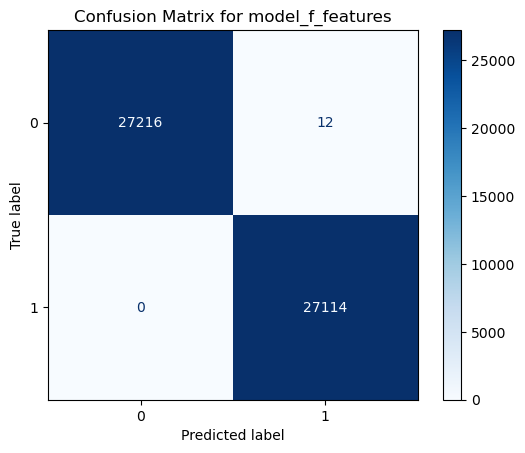

In [39]:
cm, TP, TN, FP, FN = plot_confusion(clf, X_train_f_up, y_upsampled_train_f, X_test_f_up, y_upsampled_test_f, 'model_f_features')

In [40]:
# On the first run the parameters of the quadrant where the nu
Q1 = TN
Q2 = FP
Q3 = FN
Q4 = TP

donation_gained = Q4 * 15.6
unexpected_donation = Q3 * 15.6
spend_marketing = (Q4+Q2) * 0.68
no_return_marketing = Q2 * 0.68
overall_revenue = (donation_gained + unexpected_donation) - spend_marketing

print('Donation amount gained:',round(donation_gained,2))
print('Unexpected Donations:',round(unexpected_donation,2))
print('Amount spent (cost) on marketing:',round(spend_marketing,2))
print('Amount lost on marketing:',round(no_return_marketing,2))
print('Overall revenue (donation - cost):',round(overall_revenue,2))

Donation amount gained: 422978.4
Unexpected Donations: 0.0
Amount spent (cost) on marketing: 18445.68
Amount lost on marketing: 8.16
Overall revenue (donation - cost): 404532.72


In [41]:
print('In the above plot we can see that there are    ',Q3,'    people of whom the model predicts they will not donate,')
print('when they actually would donate, AKA falsely predicted non-donators.')
print('We gain a donation amount of    ',unexpected_donation,'    from this group.')
print('There are also   ', Q2 ,'    people of whom the model predicts they will donate, when they actually do not.')
print('We  lose   ', no_return_marketing,'   on mailing costs from this group.')
print('When we look at the average donation amount of someone who actually donates is around 15.62 dollars.')
print('We raise   ', overall_revenue ,'   dollars with this model.')

In the above plot we can see that there are     0     people of whom the model predicts they will not donate,
when they actually would donate, AKA falsely predicted non-donators.
We gain a donation amount of     0.0     from this group.
There are also    12     people of whom the model predicts they will donate, when they actually do not.
We  lose    8.16    on mailing costs from this group.
When we look at the average donation amount of someone who actually donates is around 15.62 dollars.
We raise    404532.72    dollars with this model.


# Target D

### Encode and scale

In [42]:
X2_train_cat = X2_train.select_dtypes(include = object).astype(str)
X2_train_num =X2_train.select_dtypes(include = np.number)
X2_test_cat = X2_test.select_dtypes(include = object).astype(str)
X2_test_num =X2_test.select_dtypes(include = np.number)

# Encode categorical features
encoder = OneHotEncoder(drop='first').fit(X2_train_cat.select_dtypes(include=object))

cols = encoder.get_feature_names_out(input_features=X2_train_cat.columns)
X2_train_cat_encode = pd.DataFrame(encoder.transform(X2_train_cat).toarray(),columns=cols)
X2_train_cat_encode.reset_index(drop = True, inplace = True)

cols = encoder.get_feature_names_out(input_features=X2_test_cat.columns)
X2_test_cat_encode = pd.DataFrame(encoder.transform(X2_test_cat).toarray(),columns=cols)
X2_test_cat_encode.reset_index(drop = True, inplace = True)

# Scale numerical features
transformer = MinMaxScaler().fit(X_train_num)

X2_train_num_norm = transformer.transform(X2_train_num)
X2_train_num_scale = pd.DataFrame(X2_train_num_norm, index = X2_train_num.index, columns=X2_train_num.columns)
X2_train_num_scale.reset_index(drop = True, inplace = True)

X2_test_num_norm = transformer.transform(X2_test_num)
X2_test_num_scale = pd.DataFrame(X2_test_num_norm, index = X2_test_num.index, columns=X2_test_num.columns)
X2_test_num_scale.reset_index(drop = True, inplace=True)


# Concatenate X train and test and resume y train and y test
X2_train_processed = pd.concat([X2_train_num_scale,X2_train_cat_encode], axis=1)
y2_train.reset_index(drop = True, inplace = True)

X2_test_processed = pd.concat([X2_test_num_scale,X2_test_cat_encode], axis=1)
y2_test.reset_index(drop = True, inplace = True)



### Feature selection

In [43]:
# Feature selection
# F test

selector2_f = SelectKBest(f_classif, k=30)
X2_train_f_test = selector2_f.fit_transform(X2_train_processed, y2_train)
X2_test_f_test = selector2_f.transform(X2_test_processed)

indices2_f = selector_f.get_support(indices=True)

# Random Forest

forest2 = RandomForestClassifier(n_estimators=100, random_state=42)
forest2.fit(X2_train_processed, y2_train)
importances2 = forest2.feature_importances_

indices2_rf = np.argsort(importances)[::-1][:30]

# KBest (chi2)

selector2_chi2 = SelectKBest(chi2, k=30)
X2_train_chi2 = selector2_chi2.fit_transform(X2_train_processed, y2_train)
X2_test_chi2 = selector2_chi2.transform(X2_test_processed)

indices2_chi2 = selector_chi2.get_support(indices=True)

### Split

In [44]:
# Split data X2_upsampled, y2_upsampled 
X2_train_rf_up, X2_test_rf_up, y2_upsampled_train_rf, y2_upsampled_test_rf = train_test_split(
    X2_upsampled.iloc[:, indices2_rf], y2_upsampled, test_size=0.3, random_state=42
)

X2_train_f_up, X2_test_f_up, y2_upsampled_train_f, y2_upsampled_test_f = train_test_split(
    X2_upsampled.iloc[:, indices2_f], y2_upsampled, test_size=0.3, random_state=42
)

X2_train_chi2_up, X2_test_chi2_up, y2_upsampled_train_chi2, y2_upsampled_test_chi2 = train_test_split(
    X2_upsampled.iloc[:, indices2_chi2], y2_upsampled, test_size=0.3, random_state=42
)


### Pre-Model

X2_train_rf - TrainSet Accuracy:  0.6908419823969211
X2_train_rf - TestSet Accuracy:  0.674818740568989


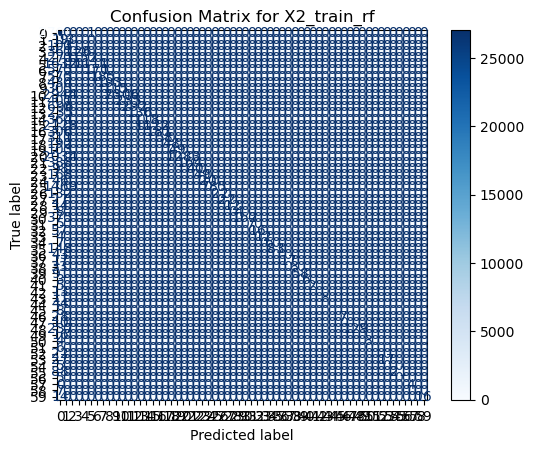

X2_train_f - TrainSet Accuracy:  0.7468058929303764
X2_train_f - TestSet Accuracy:  0.7319200618306282


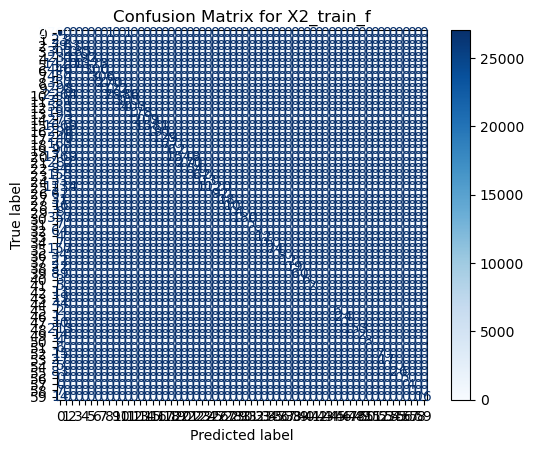

X2_train_chi2 - TrainSet Accuracy:  0.7917442190605382
X2_train_chi2 - TestSet Accuracy:  0.7753671193551949


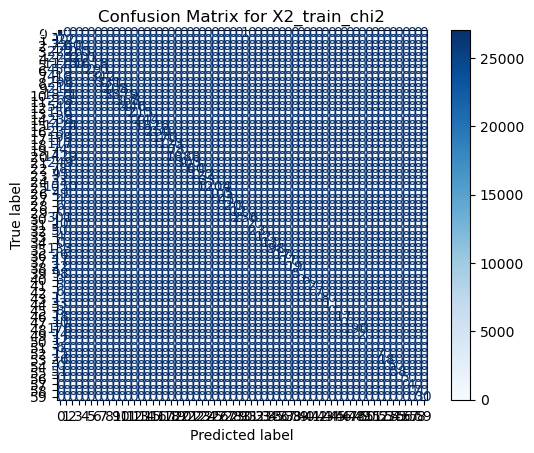

(0.7917442190605382, 0.7753671193551949, 22, 27041, 0, 10)

In [45]:
# Create the X_train datasets based on selected features

evaluate_model(X2_train_rf_up, X2_test_rf_up, y2_upsampled_train_rf, y2_upsampled_test_rf, 'X2_train_rf')
evaluate_model(X2_train_f_up, X2_test_f_up, y2_upsampled_train_f, y2_upsampled_test_f, 'X2_train_f')
evaluate_model(X2_train_chi2_up, X2_test_chi2_up, y2_upsampled_train_chi2, y2_upsampled_test_chi2, 'X2_train_chi2')

In [46]:
# For improving the result further I will select f-test

### Improving the model

In [47]:
%time
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, n_iter=10, cv=5)
random_search.fit(X2_train_f_up, y2_upsampled_train_f)
best_params = random_search.best_params_

clf2 = RandomForestClassifier(**best_params)
clf2.fit(X2_train_f_up, y2_upsampled_train_f)

# Evaluate the model
cv_scores = cross_val_score(clf2, X2_train_f_up, y2_upsampled_train_f, cv=5)
train_accuracy2 = clf.score(X2_train_f_up, y2_upsampled_train_f)
test_accuracy2 = clf.score(X2_test_f_up, y2_upsampled_test_f)

print(f'Cross-validation scores: {cv_scores}')
print(f'TrainSet Accuracy: {train_accuracy2:.4f}')
print(f'TestSet Accuracy: {test_accuracy2:.4f}')

# Plot the confusion matrix
y2_pred = clf2.predict(X2_test_f_up)
accuracy = accuracy_score(y2_upsampled_test_f, y2_pred)


CPU times: total: 0 ns
Wall time: 0 ns
Cross-validation scores: [0.98990536 0.9904176  0.99266533 0.98974723 0.98793328]
TrainSet Accuracy: 0.5016
TestSet Accuracy: 0.4981


### Regression models

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor


In [61]:
def models_automation(models, X_train, y_train, X_test, y_test):
    best_r2_score = -float("inf")
    best_model_name = ""

    for model in models:
        model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)

        print(f"{model.__class__.__name__}: Train Score (R-squared) -> {train_score:.4f}, Test Score (R-squared) -> {test_score:.4f}")

        if test_score > best_r2_score:
            best_r2_score = test_score
            best_model_name = model.__class__.__name__

    print(f"Best Performing Model: {best_model_name} (Test R-squared: {best_r2_score:.4f})")

In [62]:
model_list = [LinearRegression(), SGDRegressor(), KNeighborsRegressor(), MLPRegressor(), DecisionTreeRegressor(), RandomForestRegressor()]
models_automation(model_list, X2_train_f_up, y2_upsampled_train_f, X2_test_f_up, y2_upsampled_test_f)

LinearRegression: Train Score (R-squared) -> 0.0017, Test Score (R-squared) -> 0.0014
SGDRegressor: Train Score (R-squared) -> -48887492371908713360272436232192.0000, Test Score (R-squared) -> -49151817298241690889574642876416.0000
KNeighborsRegressor: Train Score (R-squared) -> 0.8872, Test Score (R-squared) -> 0.7983
MLPRegressor: Train Score (R-squared) -> -2.6787, Test Score (R-squared) -> -2.6995
DecisionTreeRegressor: Train Score (R-squared) -> 1.0000, Test Score (R-squared) -> 0.8880
RandomForestRegressor: Train Score (R-squared) -> 0.9960, Test Score (R-squared) -> 0.9754
Best Performing Model: RandomForestRegressor (Test R-squared: 0.9754)


In [ ]:
# 1. **Linear Regression:** linear regression is not suitable for the data.

# 2. **SGD Regressor:** the model is not learning effectively with stochastic gradient descent.

# 3. **K-Neighbors Regressor:** The model performs reasonably well, but there's room for improvement.

# 4. **MLP Regressor (Multi-layer Perceptron):** a neural network-based model seems to struggle with the data.

# 5. **Decision Tree Regressor:** overfitting.
        
# 6. **Random Forest Regressor:**seem to work well for the data.

# The score for the Random Forest Regressor aligns closely with the accuracy.



### Comparison prediction

In [63]:
pred_comparison = clf2.predict(df.iloc[:, indices2_f])
# df is the concatenation of xtrain and xtest processed data, meaning after cleaning but before upsampling

In [64]:
compare_df = pd.DataFrame({'Actual Values':y2, 'RandForst Predicted Values':pred_comparison})

In [65]:
compare_df[compare_df['Actual Values']!=0.0]

,Actual Values,RandForst Predicted Values
20,4,4
30,7,7
45,5,5
78,13,13
93,10,10
...,...,...
95298,20,20
95309,15,15
95398,3,3
95403,10,10


In [66]:
amount_predicted = round(compare_df['RandForst Predicted Values'].sum(),2)
amount_real = round(compare_df['Actual Values'].sum(),2)
print('the amount predicted is ',amount_predicted,'while the actual amount received is ',amount_real,'\nthis means that we unsuccessfully predicted less income by',amount_real-amount_predicted)

the amount predicted is  74759 while the actual amount received is  75663 
this means that we unsuccessfully predicted less income by 904
